# Water Surface Profile Computation

## Background

Words here

Two types of methods
1. Explicit or direct step method: distance is determined for a specified depth change
- Mostly for prismatic channels where cross-sectional properties don’t change with distance x.
2. Implicit methods: depth is computed from distance changes
- Unknown appears on both sides of the equation dy = f(y)dx
- For natural channels for which cross-sectional properties are determined beforehand at particular locations.


### Finite Difference Methods — Depth-Step Backwater Method

The depth-step refers to fixed changes in depth for which we solve to find the variable spatial steps. 
The method is a very simple method for computing water surface profiles in prismatic channels. 
A prismatic channel is a channel of uniform cross sectional geometry with constant bed (topographic) slope.

:::{note}
The textbook calls this the **Direct Step Method**
:::

In such channels with smooth (non-jump) steady flow the continunity and momentum equations are:

**Continunity**

$$Q = AV$$ 

where <br>

$Q$ is volumetric discharge, <br>
$A$ is cross sectional flow area, and<br>
$V$ is the mean section velocity. <br>

**Momentum**

$$ \frac{V}{g}\frac{dV}{dx} + \frac{dy}{dx} = S_0 - S_f $$

where $y$ is the flow depth (above the bottom), and $x$ is horizontal the distance along the channel.

For the depth-step method, the momentum equation is rewritten as a difference equation (after application of calculus to gather terms) then rearranged to solve for the spatial step dimension

$$ \frac{\frac{V_{i+1}^2}{2g}-\frac{V_i^2}{2g}}{\Delta x} + \frac{h_{i+1}-h_i}{\Delta x} = S_0 - \bar S_f$$

where $\bar S$ is the average slope of the energy grade line between two sections (along a reach of length $\Delta x$, the unknown value).

Rearrangement to isolate $\Delta x$ produces an explicit update equation that can be evaluated to find the different values of $\Delta x$ associated with different flow depths. The plot of the accumulated spatial changes versus the sum of the flow depth and bottom elevation is the water surface profile.

$$\Delta x = \frac{(y_{i+1}+\frac{V_{i+1}^2}{2g} )- (y_{i}+\frac{V_{i}^2}{2g} )}{S_0-\bar S_f}$$

The distance between two sections with known discharges is computed using the
equation, all the terms on the left hand side are known values. The mean energy
gradient ($\bar S_f$ ) is computed from the mean of the velocity, depth, area, and hydraulic radius for the two sections.

The friction slope can be computed using Manning’s, Chezy, or the Darcy-Weisbach friction equations adapted for non-circular, free-surface conduits.


### Example 1

The figure below is a backwater curve for a rectangular channel with discharge over a weir (on the right hand side — not depicted).The channel width is 5 meters, bottom slope 0.001, Manning’s n = 0.02 and discharge Q = 55.4m$^3$.

![](bw_curve1.png)

:::{note}
The figure is from: Page 85. Koutitas, C.G. (1983). Elements of Computational Hydraulics. Pentech Press, London 138p. ISBN 0-7273-0503-4
:::

Our goal is to replicate the fugure using our computational thinking (ENGR 1330) approach.  The depth-step method already described is an algorithm, we have to simply determine the direction to integrate - supply known depths at a control section and the target depth (normal) for the algorithm, and let the computer do the heavy lifting.

**Solution Script**

In [1]:
# prototype functions
def A_rect(B,y):
    A_rect = B*y
    return(A_rect)

def P_rect(B,y):
    P_rect = B + y + y
    return(P_rect)

def Rh(A,P):
    Rh = A/P
    return(Rh)

def slope_f(discharge,mannings_n,area,radius):
    slope_f = (discharge**2)*(mannings_n**2)/( (radius**(4/3))*(area**2) )
    return(slope_f)

In [2]:
# input information
begin_depth = 8
end_depth   = 5
discharge   = 55.4
how_many    = 32
manningn    = 0.020
slope       = 0.001
width       = 5

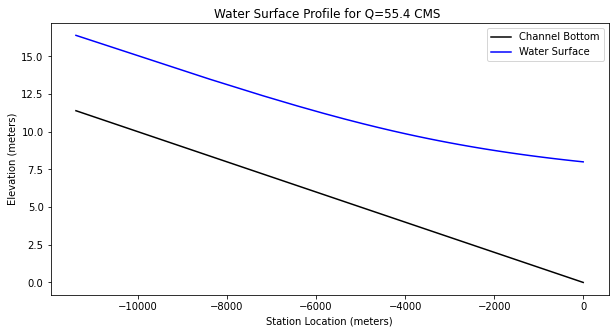

Depth at station -11393.235683125995  is 5.0


In [3]:
# empty lists for variables
depth    = [0 for i in range(how_many)] #flow depth
bse      = [0 for i in range(how_many)] #channel bottom elevation
wse      = [0 for i in range(how_many)] #water surface elevation
deltax   = [0 for i in range(how_many)] #space steps
distance = [0 for i in range(how_many)] #station locations
velocity = [0 for i in range(how_many)] #section velocity

delta_depth = (begin_depth-end_depth)/(how_many-1)# change in depth for finding spatial steps

depth[0] = (begin_depth) # assign downstream value

for i in range(how_many):
    depth[i] = (depth[0]-i*delta_depth)# depth values to evaluate
    velocity[i] = (discharge/A_rect(width,depth[i])) #velocity for each depth
    
for i in range(how_many-1):
    depth_bar     = 0.5*(depth[i]+depth[i+1])    #compute average depth in reach
    area_bar      = A_rect(width,depth_bar)      #compute average area in reach
    perimeter_bar = P_rect(width,depth_bar)  #compute average wetted perimeter
    radius_bar    = Rh(area_bar,perimeter_bar)   #compute average hydraulic radius
    friction = slope_f(discharge,manningn,area_bar,radius_bar) #compute friction slope
    deltax[i] = ((depth[i+1]+(velocity[i+1]**2)/(2*9.8)) - (depth[i] + (velocity[i]**2)/(2*9.8)))/(slope-friction)

wse[0]=bse[0]+depth[0] # water surface at control point
for i in range(1,how_many):
    distance[i] = distance[i-1]+deltax[i-1]; # station distances
    bse[i] = bse[i-1]-deltax[i-1]*slope; # bottom elevations
    wse[i] = bse[i]+depth[i] # water surface elevations

import matplotlib.pyplot as plt # the python plotting library
plottitle ='Water Surface Profile for Q=' + str(round(discharge,1)) + ' CMS '
mydata = plt.figure(figsize = (10,5)) # build a square drawing canvass from figure class
plt.plot(distance, bse, c='black') # basic line plot
plt.plot(distance, wse, c='blue') # basic line plot
plt.legend(['Channel Bottom','Water Surface'])
plt.xlabel('Station Location (meters)')
plt.ylabel('Elevation (meters)')
plt.title(plottitle)
plt.show()

print("Depth at station",distance[how_many-1]," is",depth[how_many-1])

Our plot and computed location to normal depth is for all purposes the same as the original document.

### Example 2

The figure below is another illustrative case. Here the water discharges into a horizontal channel at a rate of 1 m$^3$ per second per meter width. Assuming Manning’s n = 0.01 we wish
to compute the profile downstream of the gate and determine if it will extend to the sharp edge.

![](bw_curve2.png)

:::{note} 
The figure is from: Jaeger, C. (1957). Engineering Fluid Mechanics. St. Martin’s Press. 529p. 
:::


We would need to know the critical depth for the section (≈ 0.47meters), then compute the profile moving from the gate downstream (a frontwater curve with respect to the gate).

All we really need to do is change the starting and ending values because the script is already built for the rectangular geometry.



In [4]:
# prototype functions
def A_rect(B,y):
    A_rect = B*y
    return(A_rect)

def P_rect(B,y):
    P_rect = B + y + y
    return(P_rect)

def Rh(A,P):
    Rh = A/P
    return(Rh)

def slope_f(discharge,mannings_n,area,radius):
    slope_f = (discharge**2)*(mannings_n**2)/( (radius**(4/3))*(area**2) )
    return(slope_f)

In [5]:
# input information
begin_depth = 0.1 # at the sluice gate opening
end_depth   = 0.47 # critical depth 
discharge   = 1.0
how_many    = 32
manningn    = 0.010
slope       = 0.000
width       = 1

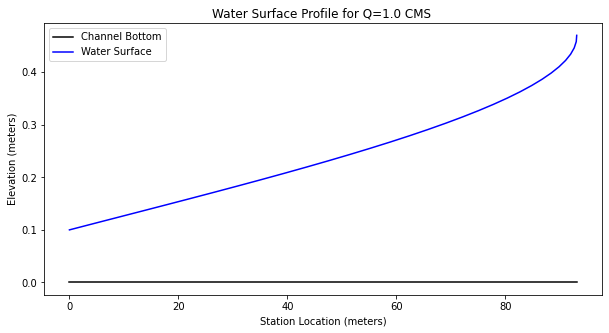

0 0.1
4.436732598938704 0.11193548387096774
8.890771308584114 0.12387096774193548
13.345925531714814 0.13580645161290322
17.78760249742602 0.147741935483871
22.202439396714528 0.1596774193548387
26.578020781699287 0.17161290322580647
30.902660708283786 0.1835483870967742
35.16523375300604 0.19548387096774195
39.35504304581471 0.20741935483870969
43.461716533328115 0.21935483870967742
47.475124951068075 0.23129032258064516
51.38531663212699 0.24322580645161293
55.182465480986565 0.25516129032258067
58.856829321149384 0.2670967741935484
62.39871647496652 0.27903225806451615
65.79845891811088 0.2909677419354839
69.04639071514907 0.3029032258064516
72.13283071890275 0.31483870967741934
75.04806872778249 0.3267741935483871
77.7823544585682 0.33870967741935487
80.32588881918448 0.35064516129032264
82.66881706565181 0.3625806451612903
84.80122350605285 0.37451612903225806
86.71312747685819 0.3864516129032258
88.39448036692608 0.3983870967741936
89.83516350466259 0.41032258064516136
91.0249867

In [6]:
# empty lists for variables
depth    = [0 for i in range(how_many)] #flow depth
bse      = [0 for i in range(how_many)] #channel bottom elevation
wse      = [0 for i in range(how_many)] #water surface elevation
deltax   = [0 for i in range(how_many)] #space steps
distance = [0 for i in range(how_many)] #station locations
velocity = [0 for i in range(how_many)] #section velocity

delta_depth = (begin_depth-end_depth)/(how_many-1)# change in depth for finding spatial steps

depth[0] = (begin_depth) # assign downstream value

for i in range(how_many):
    depth[i] = (depth[0]-i*delta_depth)# depth values to evaluate
    velocity[i] = (discharge/A_rect(width,depth[i])) #velocity for each depth
    
for i in range(how_many-1):
    depth_bar     = 0.5*(depth[i]+depth[i+1])    #compute average depth in reach
    area_bar      = A_rect(width,depth_bar)      #compute average area in reach
    perimeter_bar = P_rect(width,depth_bar)  #compute average wetted perimeter
    radius_bar    = Rh(area_bar,perimeter_bar)   #compute average hydraulic radius
    friction = slope_f(discharge,manningn,area_bar,radius_bar) #compute friction slope
    deltax[i] = ((depth[i+1]+(velocity[i+1]**2)/(2*9.8)) - (depth[i] + (velocity[i]**2)/(2*9.8)))/(slope-friction)

wse[0]=bse[0]+depth[0] # water surface at control point
for i in range(1,how_many):
    distance[i] = distance[i-1]+deltax[i-1]; # station distances
    bse[i] = bse[i-1]-deltax[i-1]*slope; # bottom elevations
    wse[i] = bse[i]+depth[i] # water surface elevations

import matplotlib.pyplot as plt # the python plotting library
plottitle ='Water Surface Profile for Q=' + str(round(discharge,1)) + ' CMS '
mydata = plt.figure(figsize = (10,5)) # build a square drawing canvass from figure class
plt.plot(distance, bse, c='black') # basic line plot
plt.plot(distance, wse, c='blue') # basic line plot
plt.legend(['Channel Bottom','Water Surface'])
plt.xlabel('Station Location (meters)')
plt.ylabel('Elevation (meters)')
plt.title(plottitle)
plt.show()

for i in range(how_many):
    print(distance[i],depth[i])

Observe that the distance is now incrementing forward (by choice of begin and end depths) when we build the plots.

Printing the distance and depth table we conclude that at the edge the flow depth is 0.35 meters - still supercritical but relatively close to the critical depth and pending instability.

## Readings

<!--1. [CE-3305-2022-2 (Summer2) Syllabus](http://54.243.252.9/ce-3305-webroot-su22/0-Syllabus/ce-3305-2022-1-syllabus.html)-->

<!--2. Hibbeler, R.C, Fluid Mechanics, 2ed. Prentice Hall, 2018. ISBN: 9780134655413 pp. 3-14-->

3. DF Elger, BC Williams, Crowe, CT and JA Roberson, *Engineering Fluid Mechanics 10th edition*, John Wiley & Sons, Inc., 2013. <!--[http://54.243.252.9/ce-3305-webroot/3-Readings/EFM-21.pdf](http://54.243.252.9/ce-3305-webroot/3-Readings/EFM-1.pdf)-->

<!--4. Cleveland, T. G. (2014) *Fluid Mechanics Notes to Accompany CE 3305 at Jade-Holshule (TTU Study Abroad 2015-2019)*, Department of Civil, Environmental, and Construction Engineering, Whitacre College of Engineering. [http://54.243.252.9/ce-3305-webroot/3-Readings/ce3305-lecture-001.1.pdf](http://54.243.252.9/ce-3305-webroot/3-Readings/ce3305-lecture-001.1.pdf)-->